In [1]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
from datetime import datetime
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statistics import mean

In [2]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")[2].rename(columns={"Symbol":"ticker"})

In [3]:
def calculate_technical_indicators(price):
    # Average Return
    price["average_return"] = price["adjclose"].pct_change(5).rolling(100).mean()
    price["prev_return"] = price["adjclose"].pct_change(5)
    
    # Coefficient of Variation
    price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
    price["return_to_risk"] = price["prev_return"] / price["coev"]
    
    # Bollinger Bands
    price["bollinger"] = ((price["adjclose"].rolling(100).mean() - 2 * price["adjclose"].rolling(100).std()) - price["adjclose"]) / price["adjclose"]

    # RSI (Relative Strength Index)
    delta = price["adjclose"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    price["rsi"] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    ema_12 = price["adjclose"].ewm(span=12, adjust=False).mean()
    ema_26 = price["adjclose"].ewm(span=26, adjust=False).mean()
    price["macd"] = ema_12 - ema_26
    price["signal_line"] = price["macd"].ewm(span=9, adjust=False).mean()

    # EMA (Exponential Moving Average)
    price["ema_20"] = price["adjclose"].ewm(span=20, adjust=False).mean()

    # ATR (Average True Range)
    high_low = price["adjhigh"] - price["adjlow"]
    high_close = np.abs(price["adjhigh"] - price["adjclose"].shift())
    low_close = np.abs(price["adjlow"] - price["adjclose"].shift())
    tr = high_low.combine(high_close, np.maximum).combine(low_close, np.maximum)
    price["atr"] = tr.rolling(14).mean()

    # Stochastic Oscillator
    low_14 = price["adjlow"].rolling(window=14).min()
    high_14 = price["adjhigh"].rolling(window=14).max()
    price["stochastic"] = (price["adjclose"] - low_14) / (high_14 - low_14) * 100

    # On-Balance Volume (OBV)
    price["obv"] = (np.sign(price["adjclose"].diff()) * price["volume"]).fillna(0).cumsum()

    # Chaikin Money Flow (CMF)
    money_flow_multiplier = ((price["adjclose"] - price["adjlow"]) - (price["adjhigh"] - price["adjclose"])) / (price["adjhigh"] - price["adjlow"])
    money_flow_volume = money_flow_multiplier * price["volume"]
    price["cmf"] = money_flow_volume.rolling(window=20).sum() / price["volume"].rolling(window=20).sum()

    # Williams %R
    price["williams_r"] = (price["adjhigh"].rolling(14).max() - price["adjclose"]) / (price["adjhigh"].rolling(14).max() - price["adjlow"].rolling(14).min()) * -100

    # Commodity Channel Index (CCI)
    typical_price = (price["adjhigh"] + price["adjlow"] + price["adjclose"]) / 3
    price["cci"] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Parabolic SAR (Commented out as it's not supported in this code)
    # price["psar"] = ta.trend.psar(high=price["adjhigh"], low=price["adjlow"], close=price["adjclose"], step=0.02, max_step=0.2)

    # Ichimoku Cloud
    price["tenkan_sen"] = (price["adjhigh"].rolling(9).max() + price["adjlow"].rolling(9).min()) / 2
    price["kijun_sen"] = (price["adjhigh"].rolling(26).max() + price["adjlow"].rolling(26).min()) / 2
    price["senkou_span_a"] = (price["tenkan_sen"] + price["kijun_sen"]) / 2
    price["senkou_span_b"] = (price["adjhigh"].rolling(52).max() + price["adjlow"].rolling(52).min()) / 2
    
    # Force Index
    price["force_index"] = price["adjclose"].diff() * price["volume"]
    
    # Elder's Impulse System
    price["elder_impulse"] = np.where((price["adjclose"] > price["adjclose"].shift()) & (price["volume"] > price["volume"].shift()), 1, 0)
    
    # Keltner Channel
    price["keltner_upper"] = price["adjclose"].rolling(20).mean() + 2 * price["adjclose"].rolling(20).std()
    price["keltner_lower"] = price["adjclose"].rolling(20).mean() - 2 * price["adjclose"].rolling(20).std()

    # Fit ARMA(1,1) model with GARCH(1,1) errors
    returns = price[:int(price.index.size/2)]["adjclose"].pct_change(5).dropna()
    model = arch_model(returns, mean='AR', lags=1, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp='off')
    forecasts = garch_fit.forecast(horizon=returns.size)
    mean_forecast = forecasts.mean
    variance_forecast = forecasts.variance
    forecasts = [0 for i in range(price.index.size - len(mean_forecast.values[0]))]
    forecasts.extend(mean_forecast.values[0])
    price["garch"] = forecasts
    forecasts = [0 for i in range(price.index.size - len(variance_forecast.values[0]))]
    forecasts.extend(variance_forecast.values[0])
    price["garch_var"] = forecasts
    price["garch_rrr"] = price["garch"] / price["garch_var"]
    
    # Fit ARIMA model
    arima_model = ARIMA(price["adjclose"].dropna(), order=(5, 1, 0))  # Example order (p=5, d=1, q=0)
    arima_fit = arima_model.fit()
    price["arima_forecast"] = arima_fit.predict(start=0, end=len(price)-1, dynamic=False)
    for i in range(10):
        price[str(i)] = price["adjclose"].shift(i)
    price["y"] = price["adjclose"].shift(-5)
    return price


In [4]:
prices_data = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker})).sort_values("date")
        price = calculate_technical_indicators(price)
        prices_data.append(price.dropna())
    except Exception as e:
        print(ticker, str(e))
        continue
market.disconnect()

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 582/1009 [00:57<00:39, 10.82it/s]E:\projects\sapling\venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 817/1009 [01:20<00:18, 10.27it/s]E:\projects\sapling\venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See

In [5]:
prices = pd.concat(prices_data).sort_values("date")

In [6]:
# Train the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(1,1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(prices[:int(prices.index.size/2)][[str(i) for i in range(10)]].values, prices[:int(prices.index.size/2)][["y"]].values, epochs=15, batch_size=32, validation_split=0.2) 
prices["lstm"] = [x[0] for x in model.predict(prices[[str(i) for i in range(10)]].values)]
prices["lstm"] = (prices["lstm"] - prices["adjclose"]) / prices["adjclose"]

Epoch 1/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6743.1890 - val_loss: 379.0752
Epoch 2/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 326.6500 - val_loss: 312.0622
Epoch 3/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 451.0338 - val_loss: 745.8188
Epoch 4/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 423.0663 - val_loss: 204.5130
Epoch 5/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 464.0264 - val_loss: 213.8099
Epoch 6/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 447.8515 - val_loss: 588.5004
Epoch 7/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 418.4752 - val_loss: 1032.1648
Epoch 8/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 423.0208 - val_loss: 248.5042
Epoch 9/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 416.2318 - val_loss: 734.7299
Epoch 10/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 338.8224 - val_loss: 342.5450
Epoch 11/15
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 244.7868 - val

In [7]:
factors = [
           "average_return"
            ,"prev_return"
           ,"coev",
            "bollinger"
            ,"rsi","signal_line","ema_20","stochastic","atr","return_to_risk","obv","cmf","williams_r","cci","force_index","elder_impulse"
            ,"keltner_upper","keltner_lower","senkou_span_a","senkou_span_b","garch","garch_var","garch_rrr","arima_forecast"
          ]     

In [8]:
# model = XGBRegressor()
# model.fit(prices[:int(prices.index.size/2)][factors].values, prices[:int(prices.index.size/2)][["y"]].values) 
# prices["xgb"] = model.predict(prices[factors])
# prices["xgb"] = (prices["xgb"] - prices["adjclose"]) / prices["adjclose"]
# factors.append("xgb")
# factors.append("lstm")

In [9]:
prices = prices[int(prices.index.size/2):]

In [24]:
analysis = []   
positions = 10
for factor in tqdm(factors):
    for ascending in [True,False]:
        default_portfolio = [{"ticker":"","adjclose":0,"quantity":0,"buy_price":0,"position":i,"cash":10000} for i in range(positions)]
        portfolio = [position for position in default_portfolio]
        portfolios = []
        for date in list(prices["date"].unique()):
            try:
                today = prices[prices["date"]==date]
                pv = sum([asset["quantity"] * asset["adjclose"] + asset["cash"] for asset in portfolio])
                for i in range(positions):
                    asset = portfolio[i]
                    rec = today.sort_values(factor,ascending=ascending).iloc[i]
                    if asset["ticker"] == "" and asset["cash"] >=  rec["adjclose"]:
                        asset["ticker"] = rec["ticker"]
                        asset["adjclose"] = rec["adjclose"]
                        asset["quantity"] = asset["cash"] / rec["adjclose"]
                        asset["buy_price"] = rec["adjclose"]
                        asset["date"] = date
                        asset["cash"] = 0
                        portfolios.append(asset.copy())
                    else:
                        ## update
                        updates = today[today["ticker"]==asset["ticker"]].iloc[0]
                        asset["adjclose"] = updates["adjclose"]
                        asset["date"] = date
                        if rec["ticker"] != asset["ticker"]:
                            asset["cash"] = asset["adjclose"] * asset["quantity"]
                            asset["ticker"] = rec["ticker"]
                            asset["adjclose"] = rec["adjclose"]
                            asset["quantity"] = asset["cash"] / rec["adjclose"]
                            asset["buy_price"] = rec["adjclose"]
                            asset["date"] = date
                            asset["cash"] = 0
                            portfolios.append(asset.copy())
                        else:
                            portfolios.append(asset.copy())
            except Exception as e:
                print(str(e))
                continue
        states = pd.DataFrame(portfolios)
        states["pv"] = states["adjclose"] * states["quantity"]
        states = states.groupby("date").agg({"pv":"sum"}).reset_index()
        states["return"] = states["pv"].pct_change(5) * 100
        risk = abs(mean([x for x in states["return"] if x < 0]))
        analysis.append({"factor":factor,"ascending":ascending,"return":states.iloc[-1]["pv"],"risk":risk})

 21%|██████████████████████████████████████████████████▍                                                                                                                                                                                               | 5/24 [00:16<01:01,  3.25s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 25%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 6/24 [00:19<00:56,  3.12s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 29%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 7/24 [00:22<00:51,  3.06s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 33%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 8/24 [00:25<00:50,  3.13s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 16/24 [00:51<00:25,  3.23s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 17/24 [00:54<00:21,  3.14s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 18/24 [00:57<00:18,  3.07s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 19/24 [01:00<00:15,  3.03s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 20/24 [01:02<00:11,  3.00s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 23/24 [01:12<00:03,  3.17s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:15<00:00,  3.15s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


In [25]:
a = pd.DataFrame(analysis)
a["rr"] = a["return"] / a["risk"]
a.sort_values("return",ascending=False)

,factor,ascending,return,risk,rr
28,force_index,True,130910.367768,3.518812,37203.003030
32,keltner_upper,True,129085.126306,2.826548,45668.821447
16,atr,True,128110.622152,2.073407,61787.486350
46,arima_forecast,True,125985.993153,2.828557,44540.732154
36,senkou_span_a,True,122666.802612,2.910324,42148.854353
43,garch_var,False,120839.479373,3.617750,33401.832853
26,cci,True,117412.448260,1.989853,59005.588629
38,senkou_span_b,True,117205.423127,3.185974,36787.936053
12,ema_20,True,114852.885498,3.053131,37618.069348
9,rsi,False,113721.984616,1.572179,72334.001128


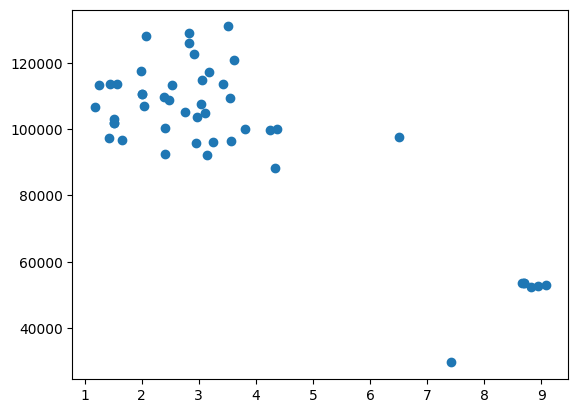

In [26]:
plt.scatter(a["risk"].values,a["return"].values)
plt.show()

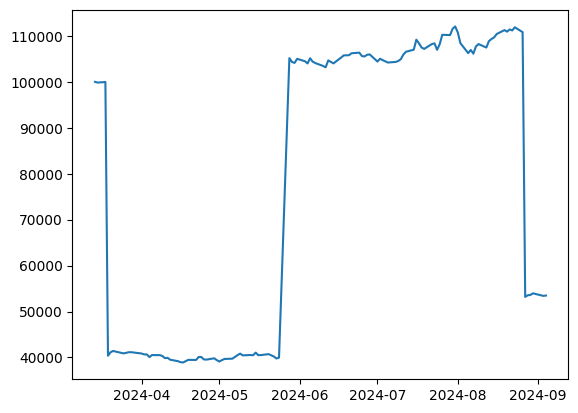

In [27]:
plt.plot(states["date"].values,states["pv"].values)
plt.show()